In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib import colors
import numpy as np
import h5py

In [2]:
file = h5py.File('GFED4.1s_1997.hdf5','r')

In [3]:
print("{:30s} :{}" .format('/', file.keys()))
print("{:30s} :{}" .format('/ancill', file['ancill'].keys()))
print("{:30s} :{}" .format('/ancill/basis_regions', file['ancill']['basis_regions']))
print("{:30s} :{}" .format('/ancill/grid_cell_area', file['ancill']['grid_cell_area']))
print()
print("{:30s} :{}" .format('/emissions', file['emissions'].keys()))
print("{:30s} :{}" .format('/emissions/01', file['emissions']['01'].keys()))
print("{:30s} :{}" .format('/emissions/01/C', file['emissions']['01']['C']))
print("{:30s} :{}" .format('/emissions/01/DM', file['emissions']['01']['DM']))
#print("{:30s} :{}" .format('/emissions/01/daily_fraction', file['emissions']['01']['daily_fraction'].keys()))
#print("{:30s} :{}" .format('/emissions/01/daily_fraction/day_1', file['emissions']['01']['daily_fraction']['day_1']))
print()
#print("{:30s} :{}" .format('/emissions/01/diurnal_cycle', file['emissions']['01']['diurnal_cycle'].keys()))
#print("{:30s} :{}" .format('/emissions/01/diurnal_cycle/UTC_0-3h', file['emissions']['01']['diurnal_cycle']['UTC_0-3h']))
print()
print("{:30s} :{}" .format('/emissions/01/partitioning', file['emissions']['01']['partitioning'].keys()))
print("{:30s} :{}" .format('/emissions/01/partitioning/DM_BORF', file['emissions']['01']['partitioning']['DM_BORF']))
print()
print("{:30s} :{}" .format('/lat', file['lat']))
print("{:30s} :{}" .format('/lon', file['lon']))

/                              :<KeysViewHDF5 ['ancill', 'biosphere', 'burned_area', 'emissions', 'lat', 'lon']>
/ancill                        :<KeysViewHDF5 ['basis_regions', 'grid_cell_area']>
/ancill/basis_regions          :<HDF5 dataset "basis_regions": shape (720, 1440), type "|u1">
/ancill/grid_cell_area         :<HDF5 dataset "grid_cell_area": shape (720, 1440), type "<f4">

/emissions                     :<KeysViewHDF5 ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']>
/emissions/01                  :<KeysViewHDF5 ['C', 'DM', 'partitioning', 'small_fire_fraction']>
/emissions/01/C                :<HDF5 dataset "C": shape (720, 1440), type "<f4">
/emissions/01/DM               :<HDF5 dataset "DM": shape (720, 1440), type "<f4">


/emissions/01/partitioning     :<KeysViewHDF5 ['C_AGRI', 'C_BORF', 'C_DEFO', 'C_PEAT', 'C_SAVA', 'C_TEMF', 'DM_AGRI', 'DM_BORF', 'DM_DEFO', 'DM_PEAT', 'DM_SAVA', 'DM_TEMF']>
/emissions/01/partitioning/DM_BORF :<HDF5 dataset "DM_B

In [4]:
a = np.array(file['lat'])
print(a.shape)
a

(720, 1440)


array([[ 89.875,  89.875,  89.875, ...,  89.875,  89.875,  89.875],
       [ 89.625,  89.625,  89.625, ...,  89.625,  89.625,  89.625],
       [ 89.375,  89.375,  89.375, ...,  89.375,  89.375,  89.375],
       ...,
       [-89.375, -89.375, -89.375, ..., -89.375, -89.375, -89.375],
       [-89.625, -89.625, -89.625, ..., -89.625, -89.625, -89.625],
       [-89.875, -89.875, -89.875, ..., -89.875, -89.875, -89.875]],
      dtype=float32)

In [7]:
months       = '01','02','03','04','05','06','07','08','09','10','11','12'
#sources      = ['SAVA','BORF','TEMF','DEFO','PEAT','AGRI']
sources      = ['BORF']

# in this example we will calculate annual CO emissions for the 14 GFED 
# basisregions over 1997-2014. Please adjust the code to calculate emissions
# for your own specie, region, and time period of interest. Please
# first download the GFED4.1s files and the GFED4_Emission_Factors.txt
# to your computer and adjust the directory where you placed them below

directory    = 'C:/Users/DinhMenh/Desktop/aaaaaa/'


"""
Read in emission factors
"""
species = [] # names of the different gas and aerosol species
EFs     = np.zeros((41, 6)) # 41 species, 6 sources

k = 0
f = open(directory+'/GFED4_Emission_Factors.txt')
while 1:
    line = f.readline()
    if line == "":
        break
        
    if line[0] != '#':
        contents = line.split()
        species.append(contents[0])
        EFs[k,:] = contents[1:]
        k += 1
                
f.close()

# we are interested in CO for this example (4th row):
#EF_CO2 = EFs[2,:]
EF_CO2 = [EFs[2,2]]
start_year = 1997
end_year   = 2022
data_all = []


"""
make table with summed DM emissions for each region, year, and source
"""
CO2_table = np.zeros((15, end_year - start_year + 1)) # region, year

for year in range(start_year, end_year+1):
    string = directory+'/GFED4.1s_'+str(year)+'.hdf5'
    f = h5py.File(string, 'r')
    
    
    if year == start_year: # these are time invariable    
        basis_regions = f['/ancill/basis_regions'][:]
        grid_area     = f['/ancill/grid_cell_area'][:]
    
    
    #CO2_emissions = np.zeros((720, 1440))
    for month in range(12):
        CO2_emissions = np.zeros((720, 1440))
        # read in DM emissions
        string = '/emissions/'+months[month]+'/DM'
        DM_emissions = f[string][:]
        for source in range(len(sources)):
            # read in the fractional contribution of each source
            string = '/emissions/'+months[month]+'/partitioning/DM_'+sources[source]
            contribution = f[string][:]
            # calculate CO emissions as the product of DM emissions (kg DM per 
            # m2 per month), the fraction the specific source contributes to 
            # this (unitless), and the emission factor (g CO per kg DM burned)
            CO2_emissions += DM_emissions * contribution * EF_CO2[source]
        
        data_all.append(grid_area* CO2_emissions / 1E12)
    
#     # fill table with total values for the globe (row 15) or basisregion (1-14)
#     for region in range(15):
#         if region == 14:
#             mask = np.ones((720, 1440))
#         else:
#             mask = basis_regions == (region + 1)            
#         CO2_table[region, year-start_year] = np.sum(grid_area * mask * CO2_emissions)
        
    print(year)
data_all = np.array(data_all)

# # convert to Tg CO 
# CO2_table = CO2_table / 1E12
# print(CO2_table.shape)
# print(CO2_table)

# please compare this to http://www.falw.vu/~gwerf/GFED/GFED4/tables/GFED4.1s_CO.txt

1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022


In [34]:
with open('data_all.npy' , 'wb') as f:
    np.save(f,data_all)
with open('data_all.npy' , 'rb') as f:
    test = np.load(f)
print(test.shape)

(312, 720, 1440)


In [92]:
def generate_X_Y(data,interval= 12):
    X = []
    Y = []
    for i in tqdm(range(data.shape[0] - interval*2), desc="Step"):
        X.append(data[i         :i+   interval])
        Y.append(data[i+interval:i+ 2*interval])
        
    X = np.array(X)
    Y = np.array(Y)
    return X, Y
        

In [93]:
X, Y = generate_X_Y(data_all)

Step:   0%|          | 0/288 [00:00<?, ?it/s]

MemoryError: Unable to allocate 26.7 GiB for an array with shape (288, 12, 720, 1440) and data type float64

In [ ]:
print(X.shape)
print(Y.shape)

<Figure size 640x480 with 0 Axes>

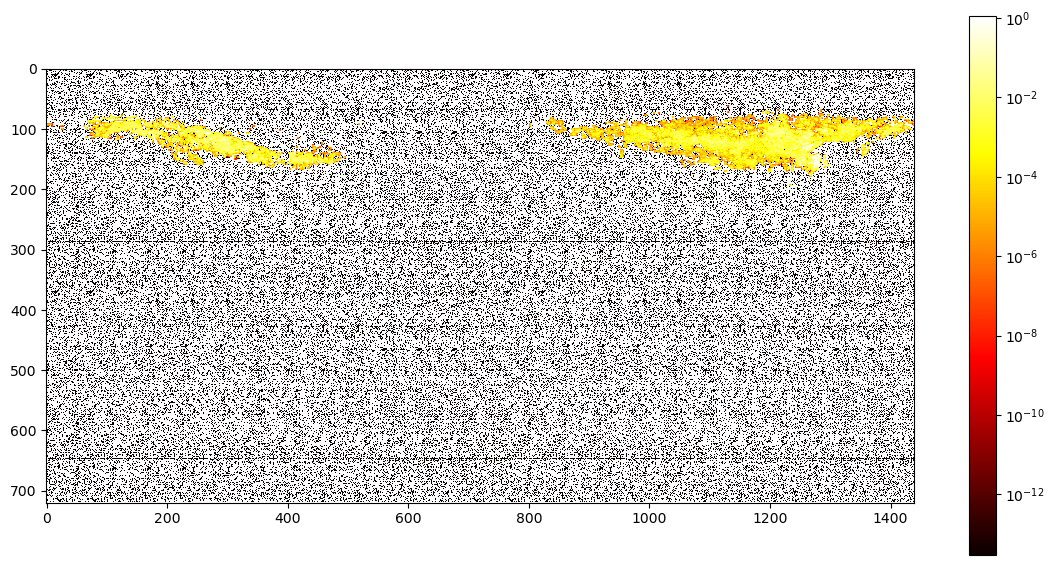

In [33]:
plt.clf()
plt.figure(figsize=(14,7))
im = plt.imshow(data_all[18] ,cmap='hot',norm=colors.LogNorm(vmin=None, vmax=1.1))
plt.colorbar(im)
plt.show()